In [2]:
import json
import matplotlib.pyplot as plt

%matplotlib inline

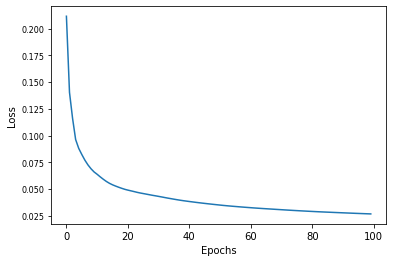

In [3]:
with open('./ckpt/SGD_0.1_MSE_batch100_100epoch_div8_unbalanced/loss.json') as f:
  losses = json.loads(f.read())

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

# plt.xticks(range(0, 500000, 50000),fontsize=8)
plt.yticks(fontsize=8)

plt.plot(losses['loss'])
